# Centroid Proximity
a.stein 6.21.2023

Can I find like drought events via how close in proximity their centroids are?

In [1]:
import pickle
import numpy as np

import sys
sys.path.append('../../../')
import ndrought.drought_network as dnet
import ndrought.wrangle_v11 as dnw

import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
import xarray as xr

/pool0/data/steinjao/drought/drought_impact/notebooks/analysis/drought_tracks/../../../ndrought/wrangle.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Load in data
get drought track dictionaries

In [2]:
dt_path = '/pool0/home/steinjao/data/drought/drought_impact/data/drought_measures/ndrought_products/CONUS_105W/drought_tracks'

In [3]:
exp_tag = 'f25k_d1_rt20p_paired'
#exp_tag = 'f25k_d2_rt20p_paired'

In [4]:
usdm_dtd = dnw.convert_pickle_to_dtd(f'{dt_path}/USDM_tracks_{exp_tag}.pickle')

In [5]:
usdm_dtd = dnw.prune_tracks(usdm_dtd)

In [6]:
spi30d_dtd = dnw.convert_pickle_to_dtd(f'{dt_path}/spi_30d_tracks_{exp_tag}.pickle')

In [7]:
spi30d_dtd = dnw.prune_tracks(spi30d_dtd)

In [8]:
spi180d_dtd = dnw.convert_pickle_to_dtd(f'{dt_path}/spi_180d_tracks_{exp_tag}.pickle')

In [9]:
spi180d_dtd = dnw.prune_tracks(spi180d_dtd)

In [10]:
usdm_dtd.keys()

dict_keys(['x', 'y', 'u', 'v', 't', 'c', 'a', 's', 'sf', 'id'])

Get drought networks

In [11]:
dnet_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures/ndrought_products/CONUS_105W/individual_dnet'

In [12]:
exp_tag = 'f25k_d1_rt20p_paired'

In [13]:
usdm_net = dnet.DroughtNetwork.unpickle(f'{dnet_path}/USDM_net_{exp_tag}.pickle')

In [14]:
spi30d_net = dnet.DroughtNetwork.unpickle(f'{dnet_path}/spi_30d_net_{exp_tag}.pickle')

In [15]:
spi180d_net = dnet.DroughtNetwork.unpickle(f'{dnet_path}/spi_180d_net_{exp_tag}.pickle')

## Compute distance between centroids

In [21]:
usdm_x = usdm_dtd['x']
usdm_y = usdm_dtd['y']
usdm_t = usdm_dtd['t']

spi30d_x = spi30d_dtd['x']
spi30d_y = spi30d_dtd['y']
spi30d_t = spi30d_dtd['t']

spi180d_x = spi180d_dtd['x']
spi180d_y = spi180d_dtd['y']
spi180d_t = spi180d_dtd['t']

First I need to pair tracks

In [27]:
a = usdm_t[0]
a

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24])

In [28]:
b = spi30d_t[0]
b

array([ 3,  4,  5,  6,  7,  7,  8,  9, 10, 11])

In [31]:
intersect_ab = np.intersect1d(a,b)
intersect_ab

array([ 6,  7,  8,  9, 10, 11])

In [46]:
local_a = []
local_b = []

for ab in intersect_ab:
    local_a.append((np.argwhere(a == ab).flatten(), ab))
    local_b.append((np.argwhere(b == ab).flatten(), ab))

print(local_a)
print(local_b)

[(array([0]), 6), (array([1]), 7), (array([2]), 8), (array([3]), 9), (array([4]), 10), (array([5]), 11)]
[(array([3]), 6), (array([4, 5]), 7), (array([6]), 8), (array([7]), 9), (array([8]), 10), (array([9]), 11)]


In [50]:
a_x = usdm_x[0]
a_y = usdm_y[0]

b_x = spi30d_x[0]
b_y = spi30d_y[0]

In [51]:
a_x[local_a[0][0]]

array([-1282245.20949714])

In [52]:
b_x[local_b[1][0]]

array([-1634877.46961733, -1634877.46961733])

In [59]:
for e_a, e_b in zip(local_a, local_b):
    for sub_e_a in e_a[0]:
        for sub_e_b in e_b[0]:
            sub_a_x = a_x[sub_e_a]
            sub_a_y = a_y[sub_e_a]
            sub_a_t = a[sub_e_a]

            sub_b_x = b_x[sub_e_b]
            sub_b_y = b_y[sub_e_b]
            sub_b_t = b[sub_e_b]

            sub_del_x = sub_a_x - sub_b_x
            sub_del_y = sub_a_y - sub_b_y
            sub_distance = np.sqrt(np.power(sub_del_x, 2)+np.power(sub_del_y, 2))

            print(sub_a_t, sub_b_t, sub_e_a, sub_e_b, sub_distance)

6 6 0 3 1059065.541017946
7 7 1 4 976382.2476937844
7 7 1 5 976382.2476937844
8 8 2 6 1115142.736332582
9 9 3 7 1120623.049109486
10 10 4 8 1165323.2880568933
11 11 5 9 1301556.8199014426


Okay, so that gets me distances between centroids. It doesn't tell me if they intersect, but it's somewhere to start

Let's throw this in a function

In [68]:
def centroid_distance(a_t, a_x, a_y, a_id, b_t, b_x, b_y, b_id):

    intersect_distance = []

    intersect_ab_t = np.intersect1d(a_t, b_t)
    if len(intersect_ab_t) > 0 :
        local_a = []
        local_b = []

        for ab in intersect_ab_t:
            local_a.append((np.argwhere(a_t == ab).flatten(), ab))
            local_b.append((np.argwhere(b_t == ab).flatten(), ab))


        for e_a, e_b in zip(local_a, local_b):
            for sub_e_a in e_a[0]:
                for sub_e_b in e_b[0]:
                    sub_a_x = a_x[sub_e_a]
                    sub_a_y = a_y[sub_e_a]
                    sub_a_t = a_t[sub_e_a]
                    sub_a_id = a_id[sub_e_a]

                    sub_b_x = b_x[sub_e_b]
                    sub_b_y = b_y[sub_e_b]
                    sub_b_t = b_t[sub_e_b]
                    sub_b_id = b_id[sub_e_b]

                    if sub_a_t != sub_b_t:
                        raise Exception('Temporal Error')

                    sub_del_x = sub_a_x - sub_b_x
                    sub_del_y = sub_a_y - sub_b_y
                    sub_distance = np.sqrt(np.power(sub_del_x, 2)+np.power(sub_del_y, 2))

                    intersect_distance.append((sub_a_t, sub_a_id, sub_b_id, sub_distance))
    return intersect_distance


In [69]:
centroid_distance(
    usdm_t[0],usdm_x[0],usdm_y[0],usdm_dtd['id'][0],
    spi30d_t[0], spi30d_x[0], spi30d_y[0], spi30d_dtd['id'][0]
    )

[]

In [70]:
centroid_distances = []

for usdm_t, usdm_x, usdm_y, usdm_id in zip(usdm_dtd['t'], usdm_dtd['x'], usdm_dtd['y'], usdm_dtd['id']):
    for spi30d_t, spi30d_x, spi30d_y, spi30d_id in zip(spi30d_dtd['t'], spi30d_dtd['x'], spi30d_dtd['y'], spi30d_dtd['id']):
        centroid_distances.append(centroid_distance(
            usdm_t, usdm_x, usdm_y, usdm_id,
            spi30d_t, spi30d_x, spi30d_y, spi30d_id
        ))

In [71]:
centroid_distances

[[(6, 0, 10, 1059065.541017946),
  (7, 1, 11, 976382.2476937844),
  (7, 1, 11, 976382.2476937844),
  (8, 2, 13, 1115142.736332582),
  (9, 3, 16, 1120623.049109486),
  (10, 4, 18, 1165323.2880568933),
  (11, 5, 21, 1301556.8199014426)],
 [(8, 2, 14, 1544870.1177109221), (9, 3, 17, 1560433.7891550038)],
 [(10, 4, 20, 468858.9930860541),
  (11, 5, 23, 488545.50594740716),
  (11, 5, 23, 488545.50594740716),
  (12, 6, 25, 528579.191174817),
  (12, 6, 27, 456401.8691826381),
  (13, 7, 28, 367045.8533595811),
  (14, 8, 30, 332231.2798487909),
  (15, 9, 31, 314862.6562634842)],
 [(17, 11, 34, 1016640.0801196115), (18, 12, 37, 1018915.789198111)],
 [(23, 22, 40, 1955429.2107665143), (24, 24, 42, 1956247.3718974588)],
 [(24, 24, 43, 250525.54627565868)],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],


Now let's find the minimum

In [80]:
min_distance = (np.nan, np.nan, np.nan, np.inf)

for cd in centroid_distances:
    if len(cd) > 0:
        for local in cd:
            distance = local[3]
            if distance < min_distance[3]:
                min_distance = local

In [81]:
min_distance

(829, 1211, 1630, 34229.384022527345)

In [123]:
34229.384022527345/18.1e3

1.8911261890899085

So that's a centroid of nearly 2 pixels distance away ... I'd say that's p damn good

In [87]:
usdm_node = usdm_net.nodes[min_distance[1]]
usdm_node

time: 829, id: 1211

In [89]:
spi30d_node = spi30d_net.nodes[min_distance[2]]
spi30d_node

time: 829, id: 1630

In [96]:
usdm_coord_set = set(tuple(coord) for coord in usdm_node.coords)
spi30d_coords_set = set(tuple(coord) for coord in spi30d_node.coords)

intersection_set = usdm_coord_set.intersection(spi30d_coords_set)

In [97]:
len(usdm_coord_set)*18.1

1549631.5000000002

In [98]:
len(spi30d_coords_set)*18.1

93739.90000000001

In [101]:
(len(intersection_set)*18.1)/(len(spi30d_coords_set)*18.1)

0.8526742614404325

In [102]:
(len(intersection_set)*18.1)/(len(usdm_coord_set)*18.1)

0.051579746539741865

In [103]:
usdm_array = usdm_net.to_array(id=1211)

In [104]:
spi30d_array = spi30d_net.to_array(id=1630)

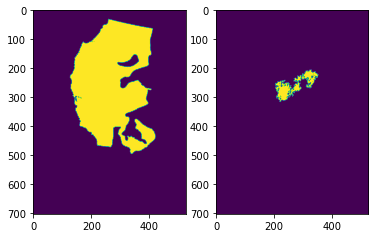

In [105]:
fig, ax = plt.subplots(1, 2)

ax[0].imshow(usdm_array[0, :, :])
ax[1].imshow(spi30d_array[0, :, :])

Okay, so those centroids are fairly close, but they're still not really the same drought based on this binary map ... what do these look like if I make them nonbinary? I'm wondering, what if similarity is cross categories? As in, USDM takes SPI very seriously and calls any drought in it a higher drought urgency?

In [107]:
paired_ds = xr.open_dataset('/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures/ndrought_products/CONUS_105W/paired_ds/usdm_spi_paired.nc')

In [121]:
set(paired_ds['spi_30d'].values.ravel())

{0.9000001,
 1.1299996,
 1.2799997,
 1.0099998,
 1.4499998,
 0.71000004,
 0.62999964,
 0.7999997,
 0.53999996,
 2.0899997,
 0.38999987,
 0.3199997,
 0.23999977,
 0.17000008,
 0.4699998,
 -0.38999987,
 1.69,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 

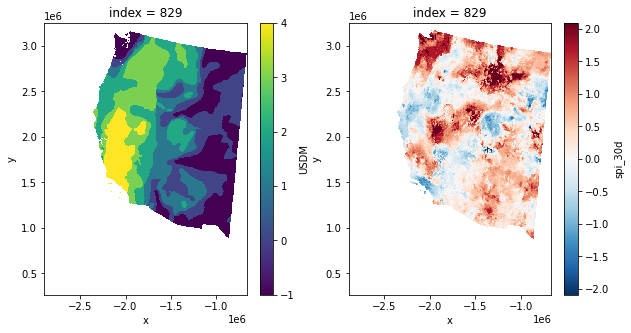

In [122]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
paired_ds.sel(index=829)['USDM'].plot(ax=ax[0], vmin=-1, vmax=4)
paired_ds.sel(index=829)['spi_30d'].plot(ax=ax[1])

Ehh, I'm not quit sure there. Feels like I'd still be hard pressed to call those the same drought. But I may be onto something with that idea of nonbinary comparison.

I know I'm comparing some of the worst to compare (USDM and SPI30d) ... but if I can find something like here, then I'm sure it'll work for ones that are better matches for each other